# K-means clustering

When working with large datasets it can be helpful to group similar observations together. This process, known as clustering, is one of the most widely used in Machine Learning and is often used when our dataset comes without pre-existing labels. 

In this notebook we're going to implement the classic K-means algorithm, the simplest and most widely used clustering method. Once we've implemented it we'll use it to split a dataset into groups and see how our clustering compares to the 'true' labelling.

## Import Modules

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


## Generate Dataset

In [2]:
modelParameters = {'mu':[[-2,1], [0.5, -1], [0,1]],
                   'pi':[0.2, 0.35, 0.45],
                   'sigma':0.4,
                   'n':200} 

#Check that pi sums to 1

if np.sum(modelParameters['pi']) != 1:
    print('Mixture weights must sum to 1!')
    
data = []

#determine which mixture each point belongs to

def generateLabels(n, pi):
    #Generate n realisations of a categorical distribution given the parameters pi
    unif = np.random.uniform(size = n) #Generate uniform random variables
    labels = [(u < np.cumsum(pi)).argmax() for u in unif] #assign cluster
    return labels

#Given the labels, generate from the corresponding normal distribution

def generateMixture(labels, params):
        
    normalSamples = []
    for label in labels:
        
        #Select Parameters
        mu = params['mu'][label]
        Sigma = np.diag([params['sigma']**2]*len(mu))
        
        
        #sample from multivariate normal
        samp = np.random.multivariate_normal(mean = mu, cov = Sigma, size = 1)
        normalSamples.append(samp)
        
    normalSamples = np.reshape(normalSamples, (len(labels), len(params['mu'][0])))
        
    return normalSamples
        

In [3]:
labels = generateLabels(100, modelParameters['pi']) #labels - (in practice we don't actually know what these are!)
X = generateMixture(labels, modelParameters) #features - (we do know what these are)

# Quickly plot the data so we know what it looks like

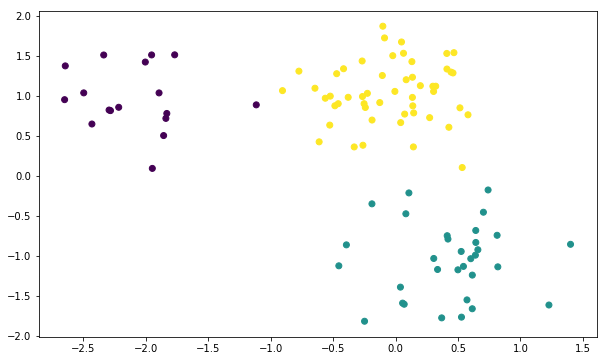

In [4]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1],c = labels)
plt.show()

When doing K-means clustering, our goal is to sort the data into 3 clusters using the data $X$. When we're doing clustering we don't have access to the colour (label) of each point, so the data we're actually given would look like this:

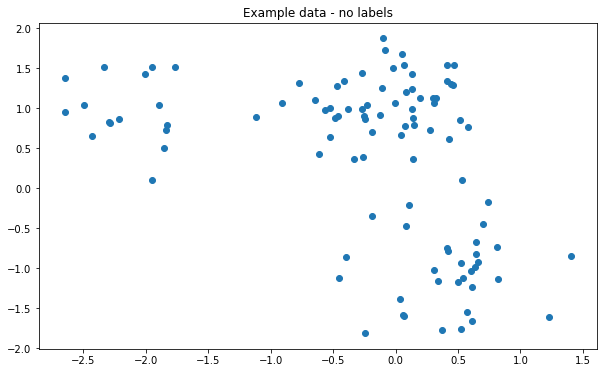

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1])
plt.title('Example data - no labels')
plt.show()

If we inspect the data we can still see that the data are roughly made up by 3 groups, one in the top left corner, one in the top right corner and one in the bottom right corner

## How does K-means work?

The K in K-means represents the number of clusters, K, that we will sort the data into.

Let's imagine we had already sorted the data into K clusters (like in the first plot above) and were trying to decide what the label of a new point should be. It would make sense to assign it to the cluster which it is closest to.

But how do we define 'closest to'? One way would be to give it the same label as the point that is closest to it (a 'nearest neighbour' approach), but a more robust way would be to determine where the 'middle' of each cluster was and assign the new point to the cluster with the closest middle. We call this 'middle' the Cluster Centroid and we calculate it be taking the average of all the points in the cluster.

That's all very well and good if we already have the clusters in place, but the whole point of the algorithm is to find out what the clusters are!

To find the clusters, we do the following:

1. Randomly initialise K Cluster Centroids
2. Assign each point to the Cluster Centroid that it is closest to.
3. Update the Cluster Centroids as the average of all points currently assigned to that centroid
4. Repeat steps 2-3 until convergence

### Why does K-means work?

Our aim is to find K Cluster Centroids such that the overall distance between each datapoint and its Cluster Centroid is minimised. That is, we want to choose cluster centroids $C = \{C_1,...,C_K\}$ such that the error function:

$$E(C) = \sum_{i=1}^n ||x_i-C_{x_i}||^2$$

is minimised, where $C_{x_i}$ is the Cluster Centroid associated with the ith observation and $||x_i-C_{x_i}||$ is the Euclidean distance between the ith observation and associated Cluster Centroid. 





Now assume after $m$ iterations of the algorithm, the current value of $E(C)$ was $\alpha$. By carrying out step 2, we make sure that each point is assigned to the nearest cluster centroid - by doing this, either $\alpha$ stays the same (every point was already assigned to the closest centroid) or $\alpha$ gets smaller (one or more points is moved to a nearer centroid and hence the total distance is reduced). Similarly with step 3, by changing the centroid to be the average of all points in the cluster, we minimise the total distance associated with that cluster, meaning $\alpha$ can either stay the same or go down.

In this way we see that as we run the algorithm $E(C)$ is non-increasing, so by continuing to run the algorithm our results can't get worse - hopefully if we run it for long enough then the results will be sensible!

In [6]:
class KMeans:
    
    def __init__(self, data, K):
        
        self.data = data #dataset with no labels
        self.K = K #Number of clusters to sort the data into
        
        #Randomly initialise Centroids
        
        self.Centroids = np.random.normal(0,1,(self.K, self.data.shape[1])) #If the data has p features then should be a K x p array
    
    def closestCentroid(self, x):
        #Takes a single example and returns the index of the closest centroid
        
        distancetoCentroids = [np.linalg.norm(x - centroid) for centroid in self.Centroids]
        return np.argmin(distancetoCentroids)
    
    def assignToCentroid(self):
        #Want to assign each observation to a centroid by passing each observation to the function closestCentroid
        
        self.assignments = [self.closestCentroid(x) for x in self.data]
            

    def updateCentroids(self):
        #Now based on the current cluster assignments (stored in self.assignments) update the Centroids
        
        for i in range(self.K):
            #For each cluster
            observationsInCluster = []
            
            
            for j, observation in enumerate(self.data):
                if self.assignments[j] == i: #If that observation is in the cluster
                    observationsInCluster.append(observation)
                    
            observationsInCluster = np.array(observationsInCluster) #Convert to a numpy array, instead of list of arrays
            self.Centroids[i] = np.mean(observationsInCluster, axis = 0) #Take the means (each observation is a 2d vector) of all observations in cluster
            
    def runKMeans(self, tolerance = 0.00001):
        #When the improvement between two successive evaluations of our error function is less than tolerance, we stop
        
        change = 1000 #Initialise change to be a big number
        numIterations = 0
        
        self.CentroidStore = [np.copy(self.Centroids)] #We want to be able to keep track of how the centroids evolved over time
        
        while change > tolerance:
            #Now we run the algorithm:
            #Save current centroid values - we'll need them to check for convergence
            self.OldCentroids = np.copy(self.Centroids) #Make sure to use copy otherwise OldCentroid will change alongside Centroids!
            
            #Assign points to closest centroid
            self.assignToCentroid()
            
            #Update Cluster Centroids
            self.updateCentroids()
    
            self.CentroidStore.append(np.copy(self.Centroids))#Store Centroid values
        
            #Calculate change in cluster centroids
            change = np.linalg.norm(self.Centroids - self.OldCentroids)
            
            #Increment iteration count
            numIterations += 1
        
        print(f'K-means Algorithm converged in {numIterations} steps')

In [7]:
myKM = KMeans(X,3)

In [8]:
myKM.runKMeans()

K-means Algorithm converged in 3 steps


## Let's plot the results

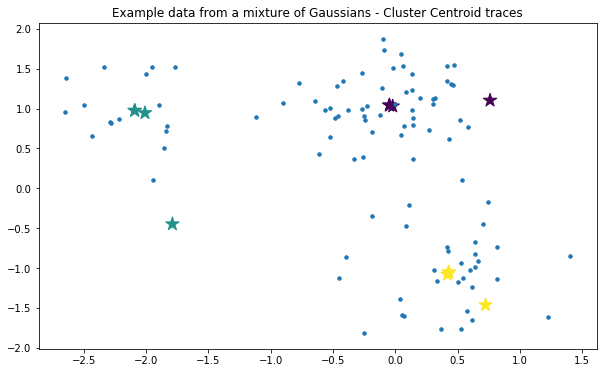

In [9]:
c = [0,1,2]*len(myKM.CentroidStore)
plt.figure(figsize=(10,6))
plt.scatter(np.array(myKM.CentroidStore).reshape(-1,2)[:,0], np.array(myKM.CentroidStore).reshape(-1,2)[:,1],c=np.array(c), s = 200, marker = '*')
plt.scatter(X[:,0], X[:,1], s = 12)
plt.title('Example data from a mixture of Gaussians - Cluster Centroid traces')
plt.show()

The stars of each colour above represents the trajectory of each cluster centroid as the algorithm progressed. Starting from a random initialisation, the centroids raplidly converged to a separate cluster, which is encouraging.

Now let's plot the data with the associated labels that we've assigned to them.

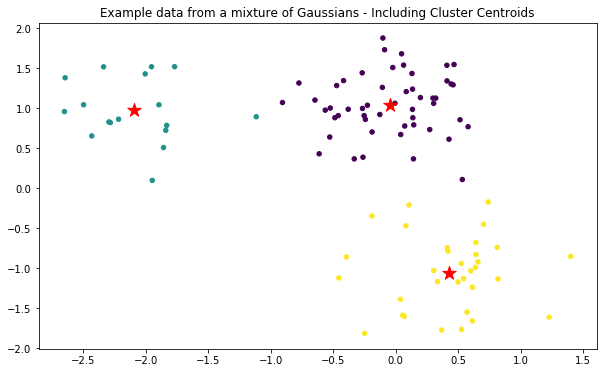

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1], s = 20, c = myKM.assignments)
plt.scatter(np.array(myKM.Centroids).reshape(-1,2)[:,0], np.array(myKM.Centroids).reshape(-1,2)[:,1], s = 200, marker = '*', c = 'red')
plt.title('Example data from a mixture of Gaussians - Including Cluster Centroids')
plt.show()

The plot above shows the final clusters (with red Cluster Centroids) assigned by the model, which should be pretty close to the 'true' clusters at the top of the page. Note: It's possible that although the clusters are the same the labels might be different - remember that K-means isn't supposed to identify the correct label, it's supposed to group the data in clusters which in reality share the same labels.



The data we've worked with in this notebook had an underlying structure that made it easy for K-means to identify distinct clusters. However let's look at an example where K-means doesn't perform so well


## The sting in the tail - A more complex data structure

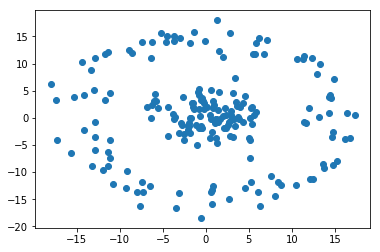

In [11]:
theta = np.linspace(0, 2*np.pi, 100)

r = 15

x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

#Perturb the values in the circle
x1 = x1 + np.random.normal(0,2,x1.shape[0])
x2 = x2 + np.random.normal(0,2,x2.shape[0])
z1 = np.random.normal(0,3,x1.shape[0])
z2 = np.random.normal(0,3,x2.shape[0])
x1 = np.array([x1,z1]).reshape(-1)
x2 = np.array([x2,z2]).reshape(-1)

plt.scatter(x1,x2)
plt.show()

It might be the case that the underlying generative structure that we want to capture is that the 'outer ring' in the plot corresponds to a certain kind of process and the 'inner circle' corresponds to another.

In [12]:
#Get data in the format we want
newX = []
for i in range(x1.shape[0]):
    newX.append([x1[i], x2[i]])
    
newX = np.array(newX)

In [13]:
#Run KMeans
myNewKM = KMeans(newX,2)
myNewKM.runKMeans()

K-means Algorithm converged in 8 steps


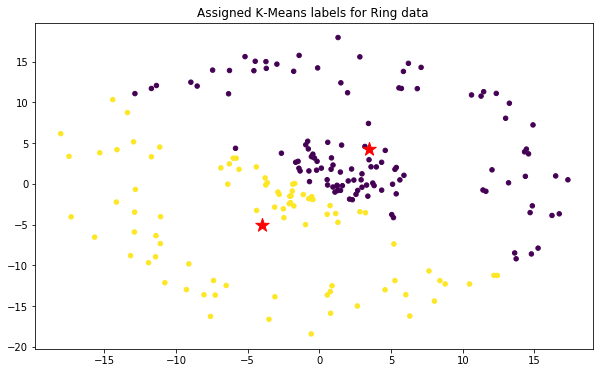

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(newX[:,0], newX[:,1], s = 20, c = np.array(myNewKM.assignments))
plt.scatter(np.array(myNewKM.Centroids).reshape(-1,2)[:,0], np.array(myNewKM.Centroids).reshape(-1,2)[:,1], s = 200, marker = '*', c = 'red')
plt.title('Assigned K-Means labels for Ring data ')
plt.show()

The above plot indicates that K-means isn't able to identify the ring-like structure that we mentioned above. The clustering it has performed is perfectly valid - remember in K-means' world, labels don't exist and this is a legitmate clustering of the data! However if we were to use this clustering our subsequent analyses might be negatively impacted. 

In a future post we'll implement a method which is capable of capturing non-linear relationships more effectively (the Gaussian Mixture Model).